# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Getting-Mean-Imputed-Temperature" data-toc-modified-id="Getting-Mean-Imputed-Temperature-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Getting Mean Imputed Temperature</a></div><div class="lev1 toc-item"><a href="#Nearby-Predictions" data-toc-modified-id="Nearby-Predictions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Nearby Predictions</a></div><div class="lev1 toc-item"><a href="#Obtaining-log-likelihoods" data-toc-modified-id="Obtaining-log-likelihoods-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Obtaining log-likelihoods</a></div>

In [3]:
const SAVED_DIR = "/Volumes/Samsung250GB/temperature_model/saved"

"/Volumes/Samsung250GB/temperature_model/saved"

In [4]:
using TimeSeries
using DataFrames
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, evaluate, metric, IsotropicData, VecF64
using GaussianProcesses: Stationary, KernelData, MatF64, predict
import GaussianProcesses: optimize!, get_optim_target, cov, grad_slice!
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
import GaussianProcesses: get_param_names, cov!, addcov!, multcov!
import Proj4
import Mamba
using JLD
using Distances
using DataFrames: by, head
using Dates: tonext, Hour, Day

In [5]:
include("src/TempModel.jl")

TempModel

In [6]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=false)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [7]:
isdList=TempModel.read_isdList()
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[:USAF].values],:]
isdSubset

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END,X_PRJ,Y_PRJ
1,725450,14990,THE EASTERN IOWA AIRPORT,US,IA,KCID,41.883,-91.717,264.6,1973,2015,1.64799e6,1.0441e6
2,725460,14933,DES MOINES INTERNATIONAL AIRPORT,US,IA,KDSM,41.534,-93.653,291.7,1973,2015,1.48723e6,1.00379e6
3,725480,94910,WATERLOO MUNICIPAL AIRPORT,US,IA,KALO,42.554,-92.401,264.6,1960,2015,1.59025e6,1.11766e6
4,725485,14940,MASON CITY MUNICIPAL ARPT,US,IA,KMCW,43.154,-93.327,373.4,1973,2015,1.51407e6,1.18374e6


In [8]:
hourly_cat=TempModel.read_Stations(isdSubset)
itest=3
hourly_train = hourly_cat[hourly_cat[:station].values.!=itest,:]
hourly_test  = hourly_cat[hourly_cat[:station].values.==itest,:]
nrow(hourly_train), nrow(hourly_test)
test_usaf=get(isdSubset[itest,:USAF])

725480

In [9]:
function subset(df, from, to; closed_start=true, closed_end=true)
    ts = df[:ts].values
    return df[argsubset(ts,from,to;closed_start=closed_start,closed_end=closed_end),:]
end
function argsubset(ts, from, to; closed_start=true, closed_end=true)
    if closed_start
        after_from = ts .>= from
    else
        after_from = ts .> from
    end
    if closed_end
        before_to = ts .<= to
    else
        before_to = ts .< to
    end
    return after_from & before_to
end

argsubset (generic function with 1 method)

In [10]:
function add_diag!(Σ::PDMats.PDMat, a::Float64)
    mat = Σ.mat
    for i in 1:size(mat,1)
        mat[i,i] += a
    end
    copy!(Σ.chol.factors, mat)
    cholfact!(Σ.chol.factors, Symbol(Σ.chol.uplo))
    @assert sumabs(mat .- full(Σ.chol)) < 1e-8
    return Σ
end
;

In [11]:
type FittingWindow
    start_date::Date
    end_date::Date
end

In [12]:
function predictions_fname(usaf::Int, fw::FittingWindow)
    return @sprintf("%d_%s_to_%s.jld", 
                    usaf, fw.start_date, fw.end_date)
end

function get_nearby(fw::FittingWindow, GPmodel::AbstractString)
    saved_dir = joinpath(SAVED_DIR, "predictions_from_nearby", GPmodel)
    pred_fname = predictions_fname(test_usaf, fw)
    nearby_pred=load(joinpath(saved_dir, pred_fname))["nearby_pred"]
end

get_nearby (generic function with 1 method)

In [13]:
function stan_dirname(usaf::Int, fw::FittingWindow)
    return @sprintf("%d_%s_to_%s/", 
                    usaf, fw.start_date, fw.end_date)
end

stan_dirname (generic function with 1 method)

In [14]:
stan_increment = Day(3)
stan_days = Day(9)
janfirst = Date(2015,1,1)
;

In [15]:
function get_test_fw(test::DataFrame, fw::FittingWindow)
    window_start = DateTime(fw.start_date) + hr_measure
    window_end = DateTime(fw.end_date) + hr_measure
    return subset(test, window_start, window_end; closed_start=false)
end
function arg_test_fw(test::DataFrame, fw::FittingWindow)
    window_start = DateTime(fw.start_date) + hr_measure
    window_end = DateTime(fw.end_date) + hr_measure
    return argsubset(test[:ts].values, window_start, window_end; closed_start=false)
end
function get_window(windownum::Int)
    stan_start = janfirst + (windownum-1)*stan_increment
    stan_end = stan_start + stan_days
    stan_fw = FittingWindow(stan_start, stan_end)
    return stan_fw
end
function window_center(fw::FittingWindow, increment::Day)
    # this doesn't generalize
    return FittingWindow(fw.start_date+increment,fw.end_date-increment-Day(1))
end

window_center (generic function with 1 method)

In [16]:
function get_chains_and_ts(fw::FittingWindow, GPmodel::AbstractString, hr_measure_fals::Hour)
    stan_fw_dir = stan_dirname(test_usaf, fw)
    stan_model_dir = joinpath(SAVED_DIR,"hr_measure", GPmodel, string(Int(hr_measure_fals)))
    stan_window_files = readdir(joinpath(stan_model_dir, stan_fw_dir))
    samplefiles = [joinpath(stan_model_dir, stan_fw_dir, f) for 
        f in stan_window_files if 
        (startswith(f,"imputation_samples") &
        endswith(f,".csv"))]
    header=String[]
    all_samples=[]
    for sf in samplefiles
        samples, header = readcsv(sf, Float64; header=true)
        push!(all_samples, samples)
    end

    samples = cat(3, all_samples...)
    chains = Mamba.Chains(samples; start=1, thin=1, chains=[i for i in 1:4], names=vec(header))
    
    ts_string = readcsv(joinpath(stan_model_dir, stan_fw_dir, "timestamps.csv"), String; header=false)
    ts = [DateTime(s, "yyyy-mm-ddTHH:MM:SS") for s in vec(ts_string)]
    return chains, ts
end

get_chains_and_ts (generic function with 1 method)

In [17]:
# convenience function to extract the imputed temperatures
# from the Mamba Chains object
function get_temperatures_reparam(chains::Mamba.Chains)
    temp_varnames = [h for h in chains.names if startswith(h, "temp_impt.")]
    temp_samples=getindex(chains, :, temp_varnames, :).value
    return temp_samples
end

get_temperatures_reparam (generic function with 1 method)

In [18]:
function get_temp_percentiles(temp_impute)
    stacked_impute=vcat((temp_impute[:,:,i] for i in 1:size(temp_impute,3))...)
    sorted_impute = sort(stacked_impute,1);
    nsamples=size(sorted_impute,1)
    # extract  10th and 90th percentiles
    # of the imputations
    imputed_10 = sorted_impute[div(nsamples,10), :]
    imputed_90 = sorted_impute[nsamples-div(nsamples,10), :]
    return imputed_10, imputed_90
end
function get_temp_mean(temp_impute)
    stacked_impute=vcat((temp_impute[:,:,i] for i in 1:size(temp_impute,3))...)
    μ = vec(mean(stacked_impute, 1))
    return μ
end

get_temp_mean (generic function with 1 method)

In [19]:
function plot_imputations(ts, temp_impute)
    imputed_10, imputed_90 = get_temp_percentiles(temp_impute)
    μ = get_temp_mean(temp_impute)
    
    plt.fill_between(ts, imputed_10, imputed_90, 
        color="#F16424", alpha=0.5, label=L"$80\%$ credible interval")
    plt.plot(ts, temp_impute[250,:,1],
        color="#009F77", label="single imputation")
    plt.plot(ts, μ, color="#F16424", linewidth=3, label="posterior mean")
end
function plot_truth(test::DataFrame)
    ts = test[:ts].values
    plt.plot(ts, test[:temp].values, 
        color="black", "o-", label="true hourly")
    plt.plot(ts, test_subsubset[:Tn].values, 
        color="blue", linewidth=3, label=L"$T_n$")
    plt.plot(ts, test_subsubset[:Tx].values, 
        color="red", linewidth=3, label=L"$T_x$")
end

plot_truth (generic function with 1 method)

# Getting Mean Imputed Temperature

In [20]:
stitched_ts_dict = Dict{Hour,Vector{DateTime}}()
stitched_mean_dict = Dict{Hour,Vector{Float64}}()

@time for hr in Hour(1):Hour(22)
    stitched_ts_dict[hr] = DateTime[]
    stitched_mean_dict[hr] = Float64[]
    println("hour: ", hr)
    for window_num in 1:120
        local chains
        local ts
        println("\twindownum: ", window_num)
        stan_fw = get_window(window_num)
        center_fw = window_center(stan_fw, stan_increment)
        GPmodel = "SExSE"
        try
            chains, ts = get_chains_and_ts(stan_fw, GPmodel, hr);
        catch
            break
        end

        temp_impute = get_temperatures_reparam(chains)
        arg_center_fw = [(center_fw.start_date <= TempModel.measurement_date(t, hr) <= center_fw.end_date)
            for t in ts]
        temp_impute_center = temp_impute[:,arg_center_fw,:]
        mean_imputation = vec(mean(temp_impute_center, (1,3)))
        @assert length(mean_imputation)==sum(arg_center_fw)
        @assert length(ts[arg_center_fw])==sum(arg_center_fw)
        append!(stitched_ts_dict[hr], ts[arg_center_fw])
        append!(stitched_mean_dict[hr], mean_imputation)
    end
end

hour: 1 hour
	windownum: 1
	windownum: 2
	windownum: 3
	windownum: 4
	windownum: 5
	windownum: 6
	windownum: 7
	windownum: 8
	windownum: 9
	windownum: 10
	windownum: 11
	windownum: 12
	windownum: 13
	windownum: 14
	windownum: 15
	windownum: 16
	windownum: 17
	windownum: 18
	windownum: 19
	windownum: 20
	windownum: 21
	windownum: 22
	windownum: 23
	windownum: 24
	windownum: 25
	windownum: 26
	windownum: 27
	windownum: 28
	windownum: 29
	windownum: 30
	windownum: 31
	windownum: 32
	windownum: 33
	windownum: 34
	windownum: 35
	windownum: 36
	windownum: 37
	windownum: 38
	windownum: 39
	windownum: 40
	windownum: 41
	windownum: 42
	windownum: 43
	windownum: 44
	windownum: 45
	windownum: 46
	windownum: 47
	windownum: 48
	windownum: 49
	windownum: 50
	windownum: 51
	windownum: 52
	windownum: 53
	windownum: 54
	windownum: 55
	windownum: 56
	windownum: 57
	windownum: 58
	windownum: 59
	windownum: 60
	windownum: 61
	windownum: 62
	windownum: 63
	windownum: 64
	windownum: 65
	windownum: 66
	windo

	windownum: 60
	windownum: 61
	windownum: 62
	windownum: 63
	windownum: 64
	windownum: 65
	windownum: 66
	windownum: 67
	windownum: 68
	windownum: 69
	windownum: 70
	windownum: 71
	windownum: 72
	windownum: 73
	windownum: 74
	windownum: 75
	windownum: 76
	windownum: 77
	windownum: 78
	windownum: 79
	windownum: 80
	windownum: 81
	windownum: 82
	windownum: 83
	windownum: 84
	windownum: 85
	windownum: 86
	windownum: 87
	windownum: 88
	windownum: 89
	windownum: 90
	windownum: 91
	windownum: 92
	windownum: 93
	windownum: 94
	windownum: 95
	windownum: 96
	windownum: 97
	windownum: 98
	windownum: 99
	windownum: 100
	windownum: 101
	windownum: 102
	windownum: 103
	windownum: 104
	windownum: 105
	windownum: 106
	windownum: 107
	windownum: 108
	windownum: 109
	windownum: 110
	windownum: 111
	windownum: 112
	windownum: 113
	windownum: 114
	windownum: 115
	windownum: 116
	windownum: 117
	windownum: 118
	windownum: 119
	windownum: 120
hour: 6 hours
	windownum: 1
	windownum: 2
	windownum: 3
	windown

	windownum: 120
hour: 10 hours
	windownum: 1
	windownum: 2
	windownum: 3
	windownum: 4
	windownum: 5
	windownum: 6
	windownum: 7
	windownum: 8
	windownum: 9
	windownum: 10
	windownum: 11
	windownum: 12
	windownum: 13
	windownum: 14
	windownum: 15
	windownum: 16
	windownum: 17
	windownum: 18
	windownum: 19
	windownum: 20
	windownum: 21
	windownum: 22
	windownum: 23
	windownum: 24
	windownum: 25
	windownum: 26
	windownum: 27
	windownum: 28
	windownum: 29
	windownum: 30
	windownum: 31
	windownum: 32
	windownum: 33
	windownum: 34
	windownum: 35
	windownum: 36
	windownum: 37
	windownum: 38
	windownum: 39
	windownum: 40
	windownum: 41
	windownum: 42
	windownum: 43
	windownum: 44
	windownum: 45
	windownum: 46
	windownum: 47
	windownum: 48
	windownum: 49
	windownum: 50
	windownum: 51
	windownum: 52
	windownum: 53
	windownum: 54
	windownum: 55
	windownum: 56
	windownum: 57
	windownum: 58
	windownum: 59
	windownum: 60
	windownum: 61
	windownum: 62
	windownum: 63
	windownum: 64
	windownum: 65
	wi

	windownum: 59
	windownum: 60
	windownum: 61
	windownum: 62
	windownum: 63
	windownum: 64
	windownum: 65
	windownum: 66
	windownum: 67
	windownum: 68
	windownum: 69
	windownum: 70
	windownum: 71
	windownum: 72
	windownum: 73
	windownum: 74
	windownum: 75
	windownum: 76
	windownum: 77
	windownum: 78
	windownum: 79
	windownum: 80
	windownum: 81
	windownum: 82
	windownum: 83
	windownum: 84
	windownum: 85
	windownum: 86
	windownum: 87
	windownum: 88
	windownum: 89
	windownum: 90
	windownum: 91
	windownum: 92
	windownum: 93
	windownum: 94
	windownum: 95
	windownum: 96
	windownum: 97
	windownum: 98
	windownum: 99
	windownum: 100
	windownum: 101
	windownum: 102
	windownum: 103
	windownum: 104
	windownum: 105
	windownum: 106
	windownum: 107
	windownum: 108
	windownum: 109
	windownum: 110
	windownum: 111
	windownum: 112
	windownum: 113
	windownum: 114
	windownum: 115
	windownum: 116
	windownum: 117
	windownum: 118
	windownum: 119
	windownum: 120
hour: 15 hours
	windownum: 1
	windownum: 2
	windo

	windownum: 117
	windownum: 118
	windownum: 119
	windownum: 120
hour: 19 hours
	windownum: 1
	windownum: 2
	windownum: 3
	windownum: 4
	windownum: 5
	windownum: 6
	windownum: 7
	windownum: 8
	windownum: 9
	windownum: 10
	windownum: 11
	windownum: 12
	windownum: 13
	windownum: 14
	windownum: 15
	windownum: 16
	windownum: 17
	windownum: 18
	windownum: 19
	windownum: 20
	windownum: 21
	windownum: 22
	windownum: 23
	windownum: 24
	windownum: 25
	windownum: 26
	windownum: 27
	windownum: 28
	windownum: 29
	windownum: 30
	windownum: 31
	windownum: 32
	windownum: 33
	windownum: 34
	windownum: 35
	windownum: 36
	windownum: 37
	windownum: 38
	windownum: 39
	windownum: 40
	windownum: 41
	windownum: 42
	windownum: 43
	windownum: 44
	windownum: 45
	windownum: 46
	windownum: 47
	windownum: 48
	windownum: 49
	windownum: 50
	windownum: 51
	windownum: 52
	windownum: 53
	windownum: 54
	windownum: 55
	windownum: 56
	windownum: 57
	windownum: 58
	windownum: 59
	windownum: 60
	windownum: 61
	windownum: 62


In [21]:
size(stitched_ts)

LoadError: UndefVarError: stitched_ts not defined

In [22]:
size(stitched_mean)

LoadError: UndefVarError: stitched_mean not defined

# Nearby Predictions

In [23]:
nearby_windows = [
    FittingWindow(Date(2015,1,1),Date(2015,3,14)),
    FittingWindow(Date(2015,1,25),Date(2015,4,8)),
    FittingWindow(Date(2015,2,18),Date(2015,5,2)),
    FittingWindow(Date(2015,3,14),Date(2015,5,26)),
    FittingWindow(Date(2015,4,8),Date(2015,6,20)),
    FittingWindow(Date(2015,5,2),Date(2015,7,14)),
    FittingWindow(Date(2015,5,26),Date(2015,8,7)),
    FittingWindow(Date(2015,6,20),Date(2015,9,1)),
    FittingWindow(Date(2015,7,14),Date(2015,9,25)),
    FittingWindow(Date(2015,8,7),Date(2015,10,19)),
    FittingWindow(Date(2015,9,1),Date(2015,11,13)),
    FittingWindow(Date(2015,9,25),Date(2015,12,7)),
    FittingWindow(Date(2015,10,19),Date(2015,12,31)),
]

13-element Array{FittingWindow,1}:
 FittingWindow(2015-01-01,2015-03-14)
 FittingWindow(2015-01-25,2015-04-08)
 FittingWindow(2015-02-18,2015-05-02)
 FittingWindow(2015-03-14,2015-05-26)
 FittingWindow(2015-04-08,2015-06-20)
 FittingWindow(2015-05-02,2015-07-14)
 FittingWindow(2015-05-26,2015-08-07)
 FittingWindow(2015-06-20,2015-09-01)
 FittingWindow(2015-07-14,2015-09-25)
 FittingWindow(2015-08-07,2015-10-19)
 FittingWindow(2015-09-01,2015-11-13)
 FittingWindow(2015-09-25,2015-12-07)
 FittingWindow(2015-10-19,2015-12-31)

In [24]:
""" 
    Is window A inside of window B?
"""
function a_isinside_b(t::DateTime, b::FittingWindow)
    start_after = t >= b.start_date
    end_before = t <= b.end_date+Day(1)
    return start_after & end_before
end
"""
    How much buffer time is there on either side of the window?
"""
function buffer(t::DateTime, b::FittingWindow)
    start_diff = abs(t - b.start_date)
    end_diff = abs(t - (b.end_date+Day(1)))
    return min(start_diff, end_diff)
end
""" 
    Amongst a list of candidate windows `cand`, find the window that includes `wind`
    with the largest buffer on either sides.
"""
function find_best_window(t::DateTime, cands::Vector{FittingWindow})
    incl_wdows = [fw for fw in cands if a_isinside_b(t, fw)]
    buffers = [buffer(t, fw) for fw in incl_wdows]
    imax = indmax(buffers)
    best_window = incl_wdows[imax]
    return best_window
end

find_best_window

In [25]:
all_nearby_preds = Dict{FittingWindow, TempModel.NearbyPrediction}()
GPmodel = "SExSE"
for fw in nearby_windows
    all_nearby_preds[fw] = get_nearby(fw, GPmodel)
end

In [26]:
stitched_nearby_mean = Float64[]
stitched_ts = stitched_ts_dict[Hour(1)]
best_pred_window = [find_best_window(t, nearby_windows) for t in stitched_ts]
for fw in nearby_windows
    ts_start, ts_end = extrema(t for (i,t) in enumerate(stitched_ts) if best_pred_window[i] == fw)
    nearby_pred = all_nearby_preds[fw]

    nrby_subset = argsubset(nearby_pred.ts, ts_start, ts_end, closed_start=true, closed_end=true)

    μ_window = nearby_pred.μ[nrby_subset]
    append!(stitched_nearby_mean, μ_window)
end

@assert length(stitched_ts) == length(stitched_nearby_mean)

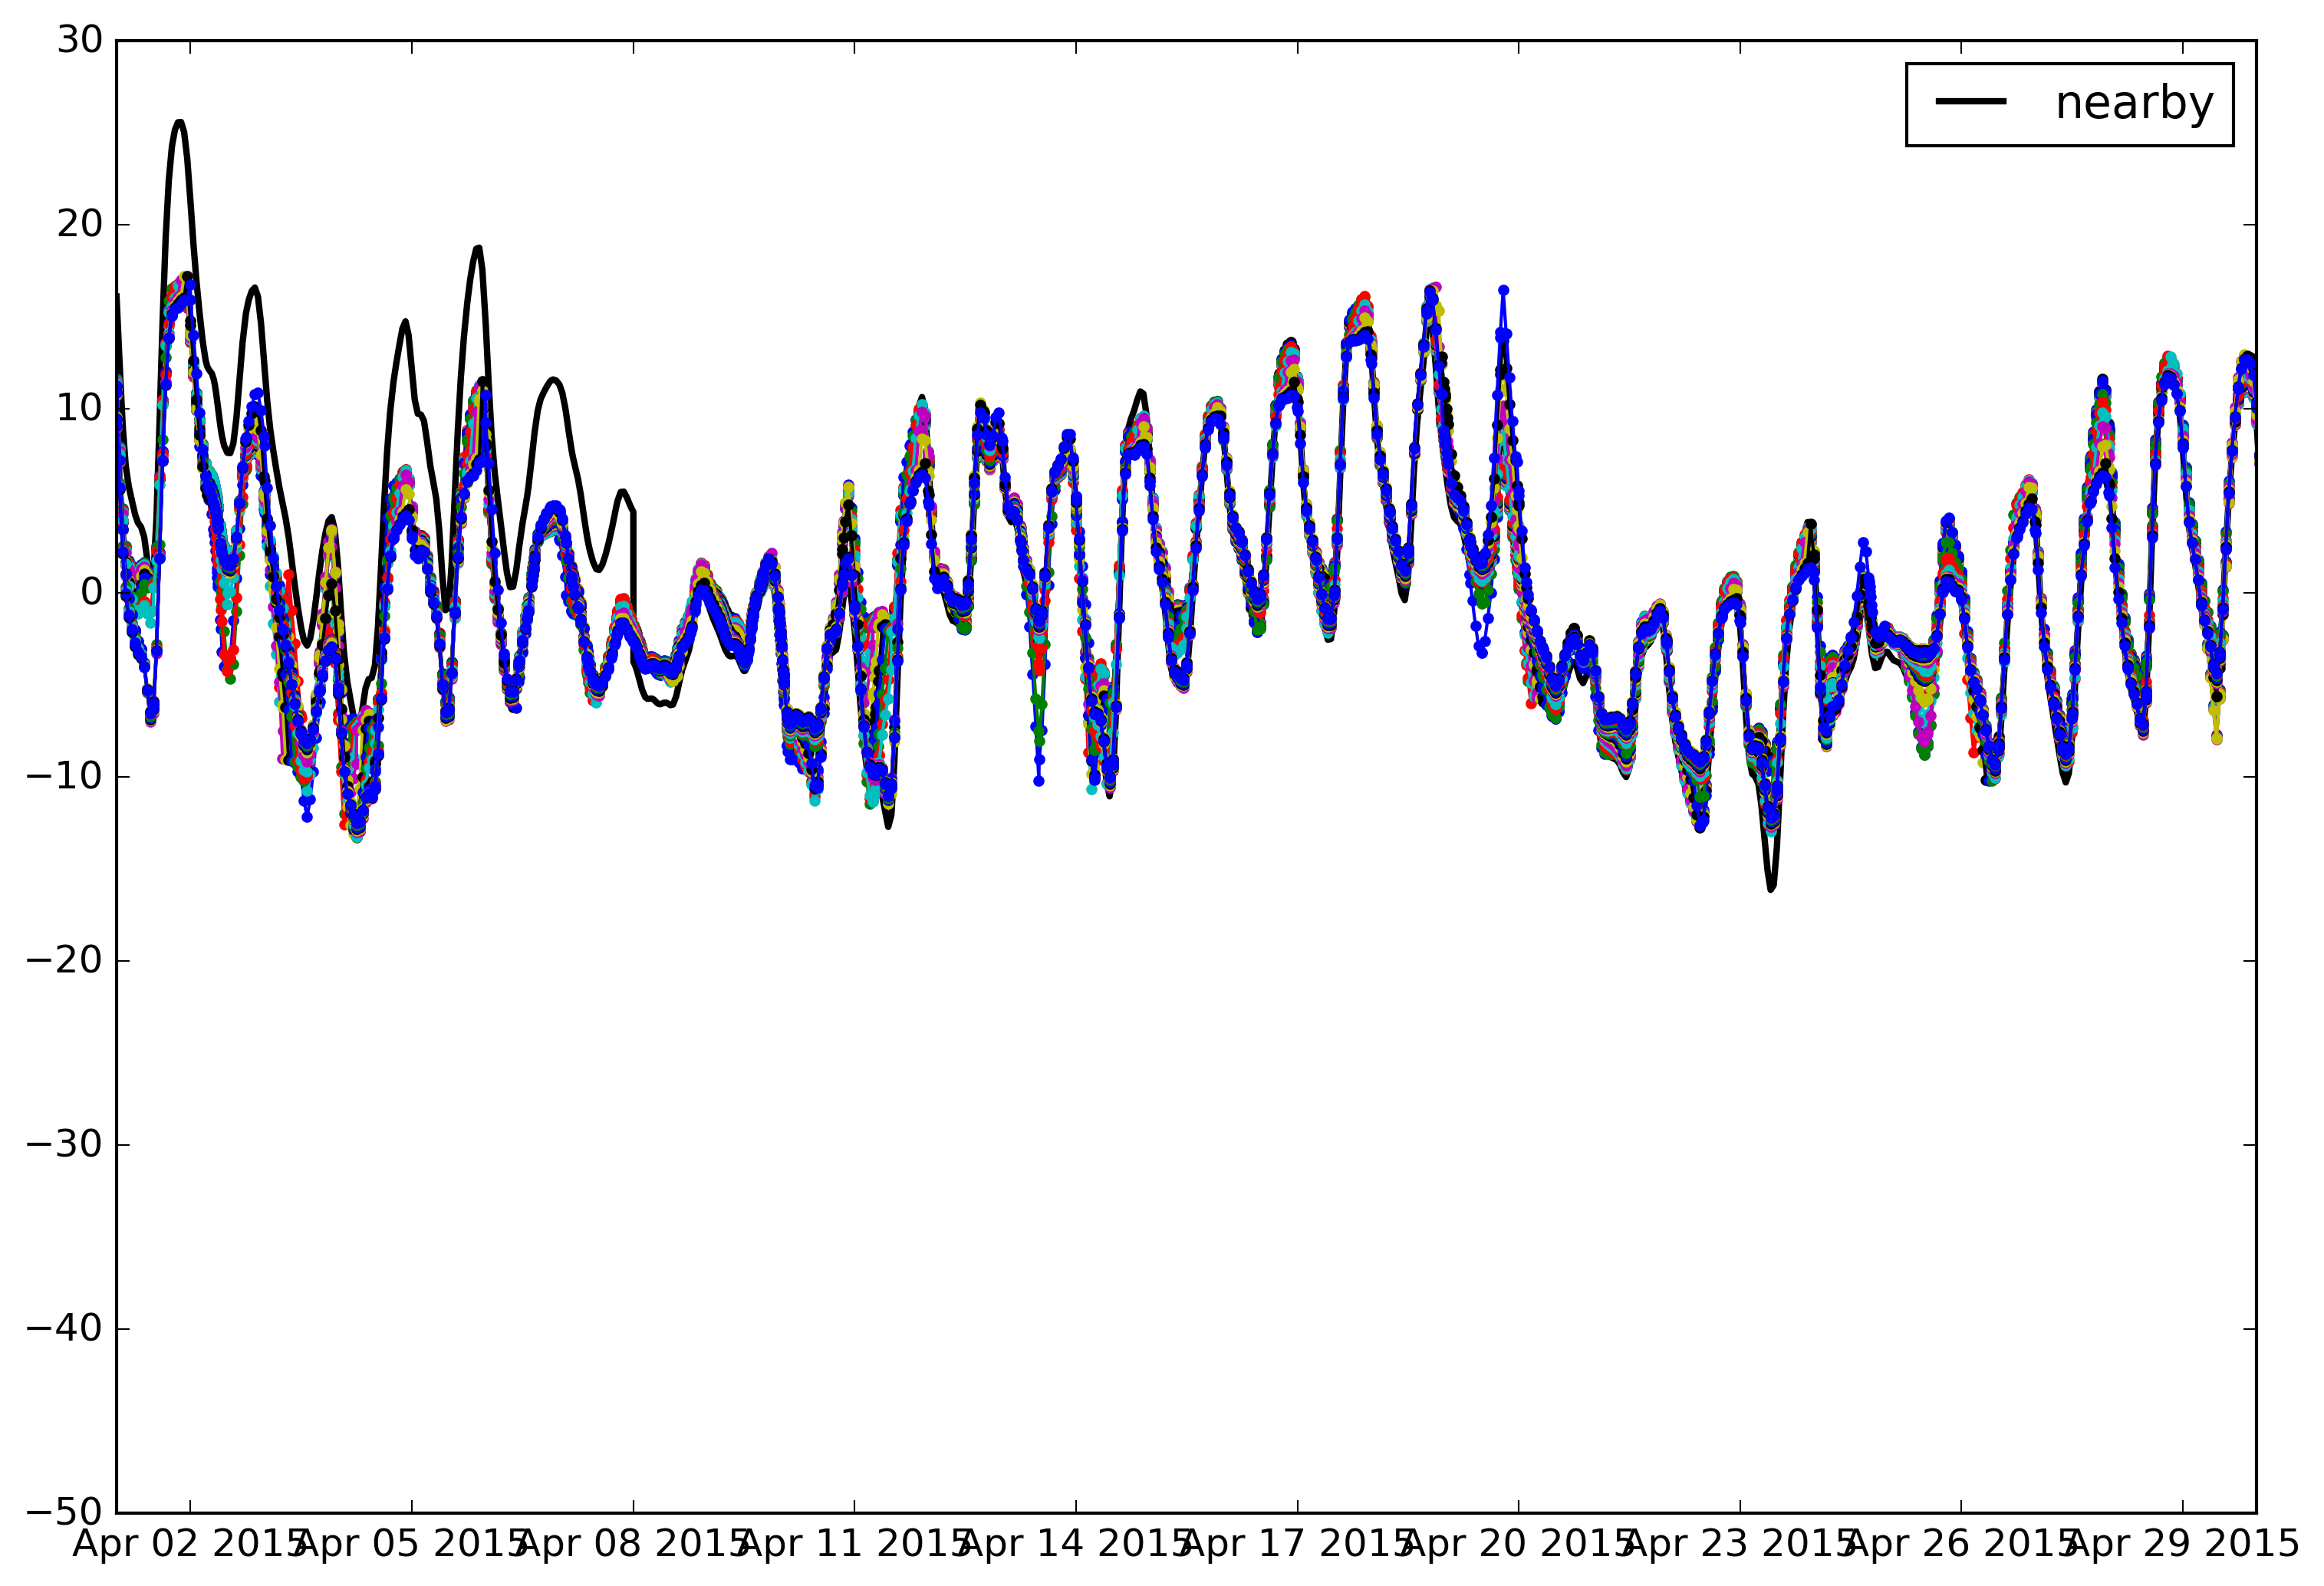

/Users/imolk/bin/venv_jupyter/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [27]:
plt.plot(stitched_ts, stitched_nearby_mean.-mean(stitched_nearby_mean), color="black", linewidth=2, label="nearby")
plt.xlim(DateTime(2015,4,1,0,0,0),DateTime(2015,4,30,0,0,0))
plt.legend(loc="best")

for hr in sort(collect(keys(stitched_ts_dict)))
    stitched_ts_ = stitched_ts_dict[hr]
    stitched_mean = stitched_mean_dict[hr]
    plt.plot(stitched_ts_, stitched_mean.-mean(stitched_mean),".-", label=@sprintf("%s",hr))
end

# Obtaining log-likelihoods

In [28]:
function ts_to_hours(ts_datetime::Vector{DateTime})
    ms_per_hour = 1e3*3600
    ts_vec = convert(Vector{Float64}, ts_datetime.-minimum(ts_datetime)) / ms_per_hour
    return ts_vec
end

ts_to_hours (generic function with 1 method)

In [29]:
kernel_slow = SEIso(log(48.0),log(5.0))
logNoise = 0.0
sumloglik_dict = Dict{Hour,Float64}()
for hr in sort(collect(keys(stitched_ts_dict)))
    stitched_ts = stitched_ts_dict[hr]
    stitched_mean = stitched_mean_dict[hr]
    best_pred_window = [find_best_window(t, nearby_windows) for t in stitched_ts]
    println("===========================================")
    println(hr)
    println("---------------")
    sumloglik = 0.0
    for fw in nearby_windows
        ts_start, ts_end = extrema(t for (i,t) in enumerate(stitched_ts) if best_pred_window[i] == fw)
        nearby_pred = all_nearby_preds[fw]

        nrby_subset = argsubset(nearby_pred.ts, ts_start, ts_end, closed_start=true, closed_end=true)
        impt_subset = argsubset(stitched_ts,    ts_start, ts_end, closed_start=true, closed_end=true)
        @assert sum(nrby_subset) == sum(impt_subset)

        μ_window = nearby_pred.μ[nrby_subset]
        Σ_window = nearby_pred.Σ.mat[nrby_subset,nrby_subset]
        
#         for i in 1:sum(nrby_subset)
#             Σ_window[i,i] += exp(2*logNoise)
#         end
        ts_window = stitched_ts[impt_subset]
        ts_hours = ts_to_hours(ts_window)
        GaussianProcesses.addcov!(Σ_window, kernel_slow, ts_hours')
        
        μ_window .-= mean(μ_window)
        nearby_distr = MultivariateNormal(μ_window, Σ_window)

        mean_impt = stitched_mean[impt_subset]
        mean_impt .-= mean(mean_impt)
        μ_logpdf    = logpdf(nearby_distr,μ_window)
        impt_logpdf = logpdf(nearby_distr,mean_impt)
        @printf("difference in log-pdf: %12.3f (%d points)\n", impt_logpdf-μ_logpdf, sum(nrby_subset))
        sumloglik += impt_logpdf-μ_logpdf
    end
    println("---------------")
    @printf("Sum of log-likelihood difference: %5.3f\n", sumloglik)
    sumloglik_dict[hr] = sumloglik
end

1 hour
---------------
difference in log-pdf:    -1432.859 (1693 points)
difference in log-pdf:     -711.587 (769 points)
difference in log-pdf:     -215.436 (773 points)
difference in log-pdf:     -249.282 (796 points)
difference in log-pdf:     -330.478 (956 points)
difference in log-pdf:     -166.346 (853 points)
difference in log-pdf:     -173.463 (886 points)
difference in log-pdf:     -158.444 (792 points)
difference in log-pdf:     -145.909 (852 points)
difference in log-pdf:     -223.475 (747 points)
difference in log-pdf:     -333.078 (726 points)
difference in log-pdf:     -389.549 (831 points)
difference in log-pdf:     -577.178 (1694 points)
---------------
Sum of log-likelihood difference: -5107.084
2 hours
---------------
difference in log-pdf:    -1179.987 (1692 points)
difference in log-pdf:     -649.358 (769 points)
difference in log-pdf:     -228.271 (773 points)
difference in log-pdf:     -236.792 (796 points)
difference in log-pdf:     -258.474 (956 points)
differen

difference in log-pdf:     -307.016 (1710 points)
---------------
Sum of log-likelihood difference: -2520.214
12 hours
---------------
difference in log-pdf:     -340.254 (1673 points)
difference in log-pdf:     -378.266 (769 points)
difference in log-pdf:      -89.085 (773 points)
difference in log-pdf:      -61.784 (796 points)
difference in log-pdf:     -113.883 (956 points)
difference in log-pdf:      -30.386 (853 points)
difference in log-pdf:      -36.466 (886 points)
difference in log-pdf:      -44.421 (792 points)
difference in log-pdf:      -56.064 (852 points)
difference in log-pdf:      -32.875 (747 points)
difference in log-pdf:      -73.397 (726 points)
difference in log-pdf:     -118.768 (831 points)
difference in log-pdf:     -240.654 (1712 points)
---------------
Sum of log-likelihood difference: -1616.303
13 hours
---------------
difference in log-pdf:     -240.817 (1670 points)
difference in log-pdf:     -235.395 (769 points)
difference in log-pdf:      -95.808 (773 p

difference in log-pdf:      -58.658 (852 points)
difference in log-pdf:      -74.185 (747 points)
difference in log-pdf:     -156.871 (726 points)
difference in log-pdf:     -133.121 (831 points)
difference in log-pdf:     -138.626 (1727 points)
---------------
Sum of log-likelihood difference: -1693.292


In [41]:
?plt.xticks


    Get or set the *x*-limits of the current tick locations and labels.

    ::

      # return locs, labels where locs is an array of tick locations and
      # labels is an array of tick labels.
      locs, labels = xticks()

      # set the locations of the xticks
      xticks( arange(6) )

      # set the locations and labels of the xticks
      xticks( arange(5), ('Tom', 'Dick', 'Harry', 'Sally', 'Sue') )

    The keyword args, if any, are :class:`~matplotlib.text.Text`
    properties. For example, to rotate long labels::

      xticks( arange(12), calendar.month_name[1:13], rotation=17 )
    

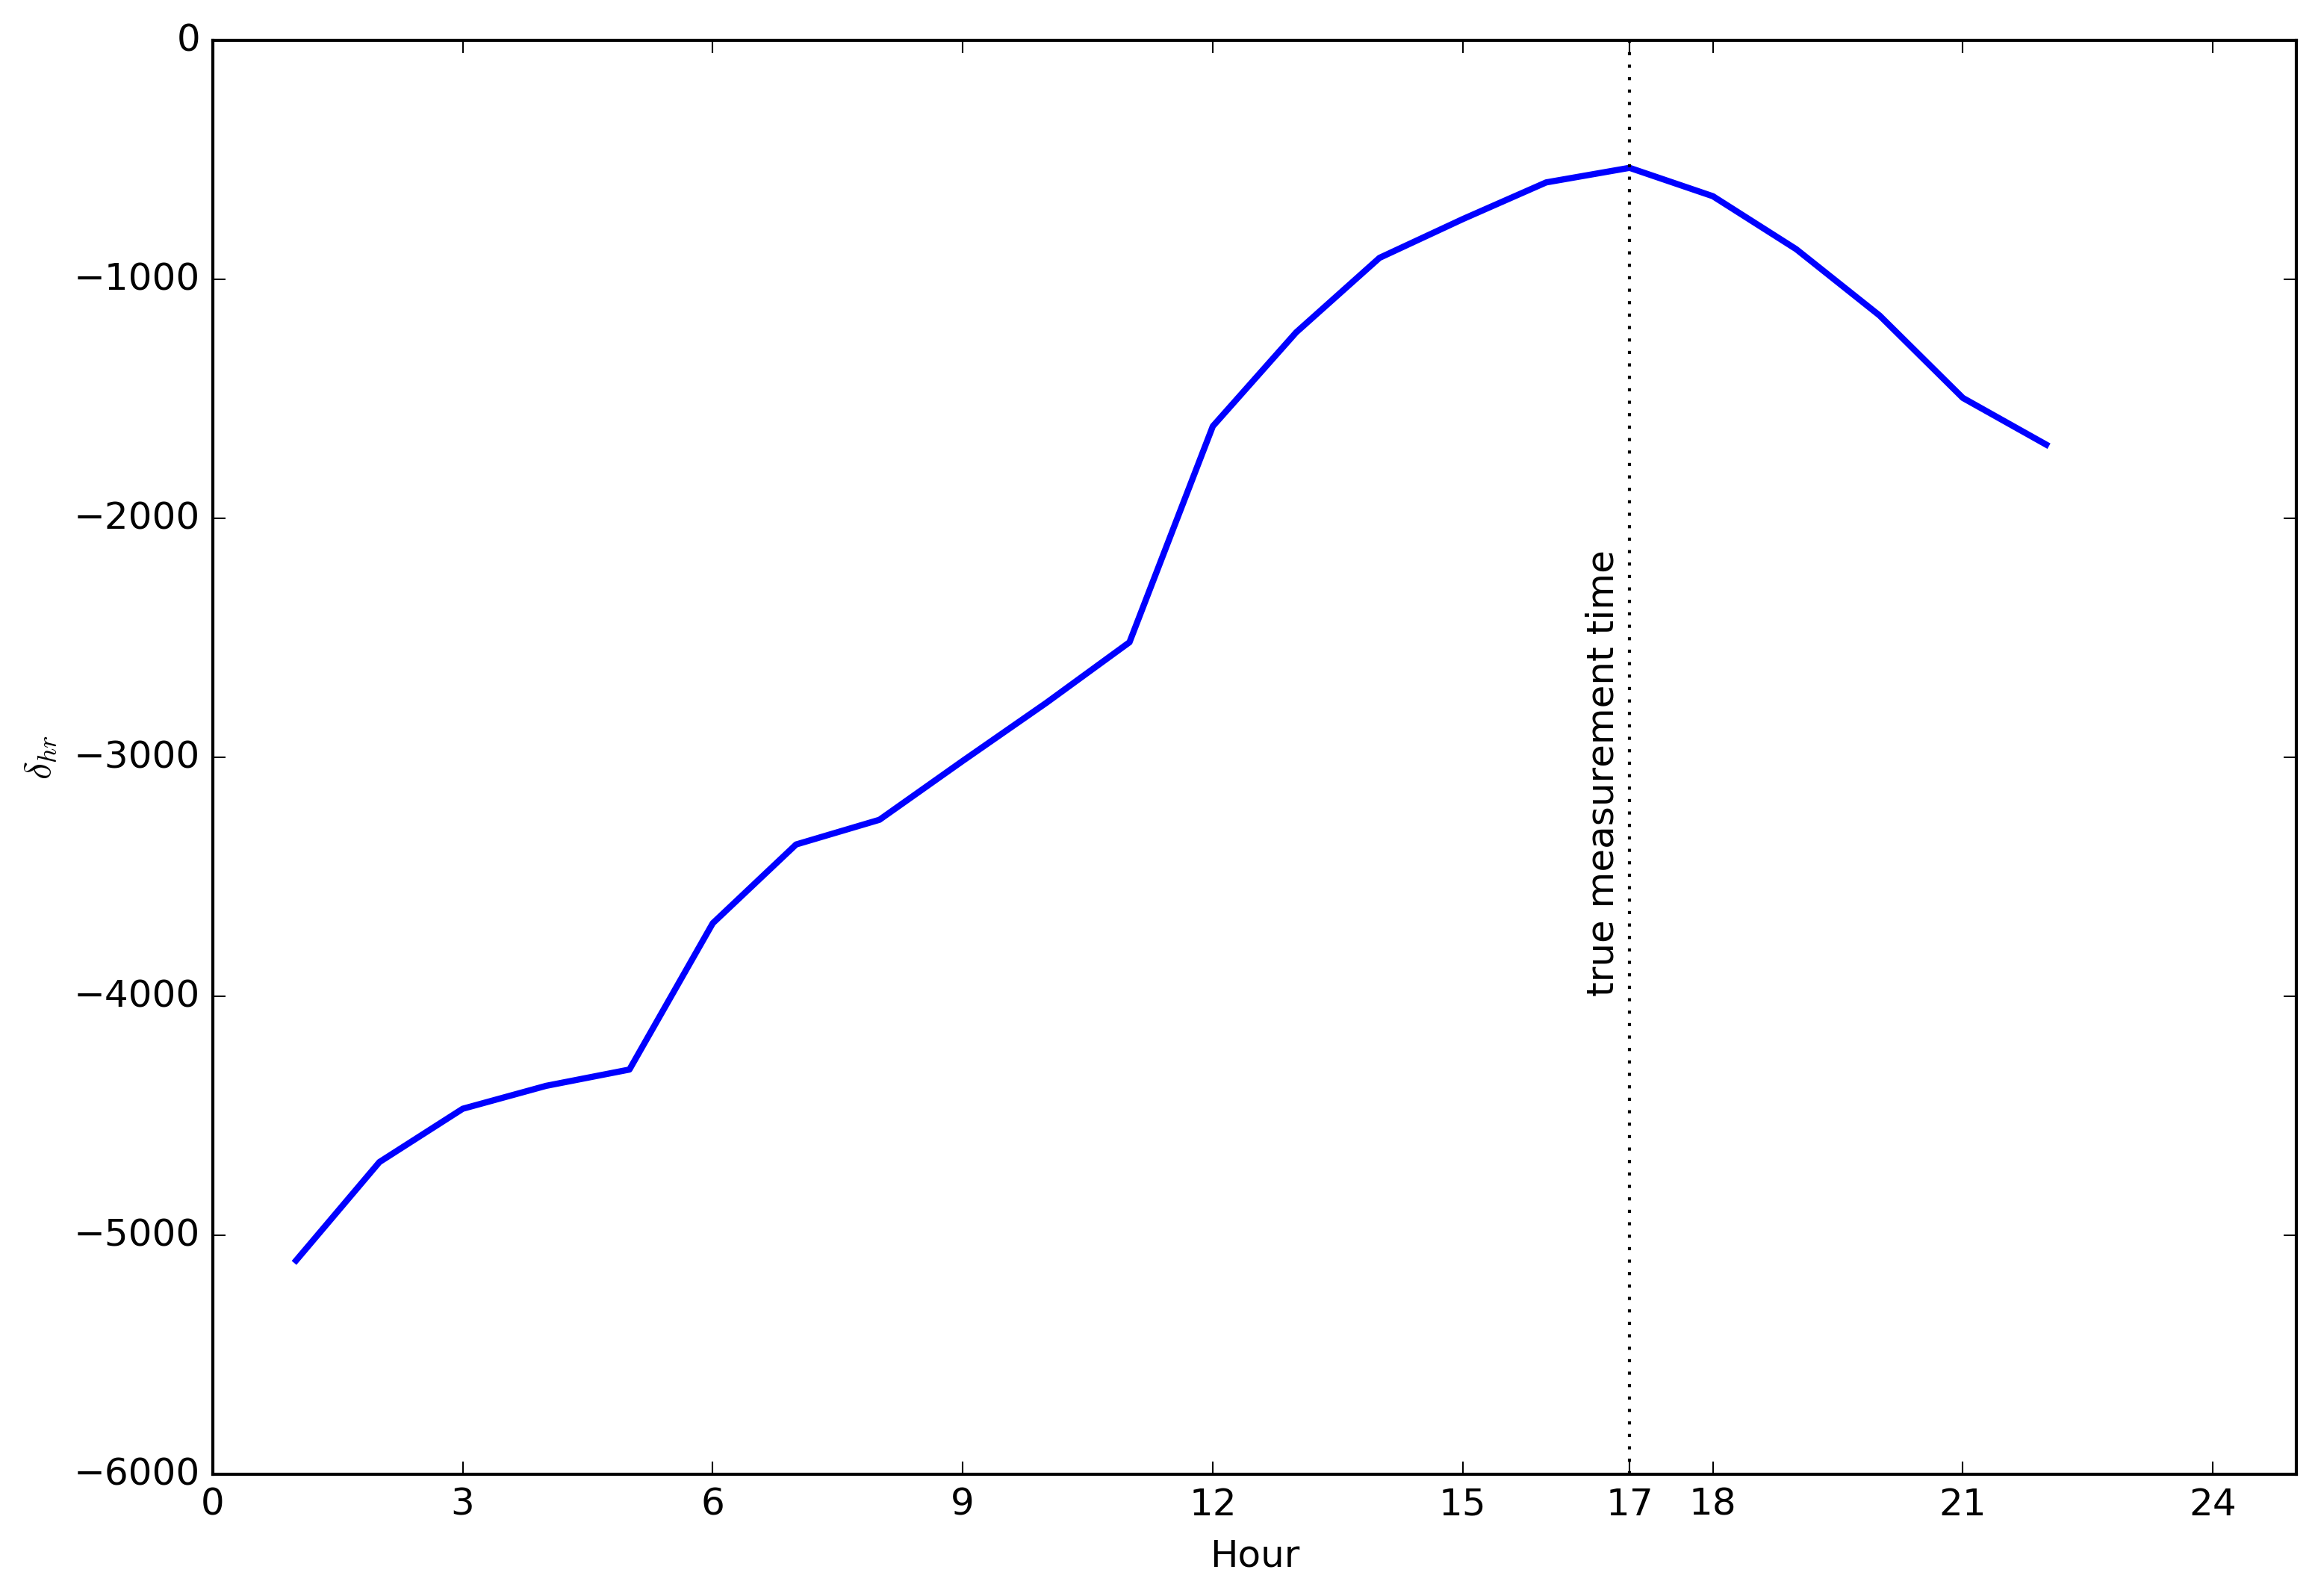

In [49]:
hours_vec = sort(collect(keys(sumloglik_dict)))
sumloglik_vec = [sumloglik_dict[hr] for hr in hours_vec]
plt.plot(convert(Vector{Float64},hours_vec), sumloglik_vec, linewidth=2)
plt.axvline(17, linestyle=":", color="black")
plt.xlabel("Hour")
plt.ylabel(L"$\delta_{hr}$")
# plt.text(3, -1000, 
#     L"\log \mathbb{P}\left( \mathrm{T}_{\mathrm{miss}} = \mathbb{E}\left( \mathrm{T}_{\mathrm{miss}} \mid \mathrm{T}_{\mathrm{obs}}, \mathrm{T}_{n}, \mathrm{T}_{x}, \mathtt{hour}, \hat{\theta} \right) \mid \mathrm{T}_{\mathrm{obs}}, \hat{\theta} \right)")
plt.text(16.9,-4000, "true measurement time", rotation=90.0, horizontalalignment="right",
    verticalalignment="bottom"
    )
plt.xticks([0,3,6,9,12,15,17,18,21,24], ["0","3","6","9","12","15","17","18","21","24"])
plt.savefig("figures/hr_inference.png")
plt.savefig("figures/hr_inference.pdf")

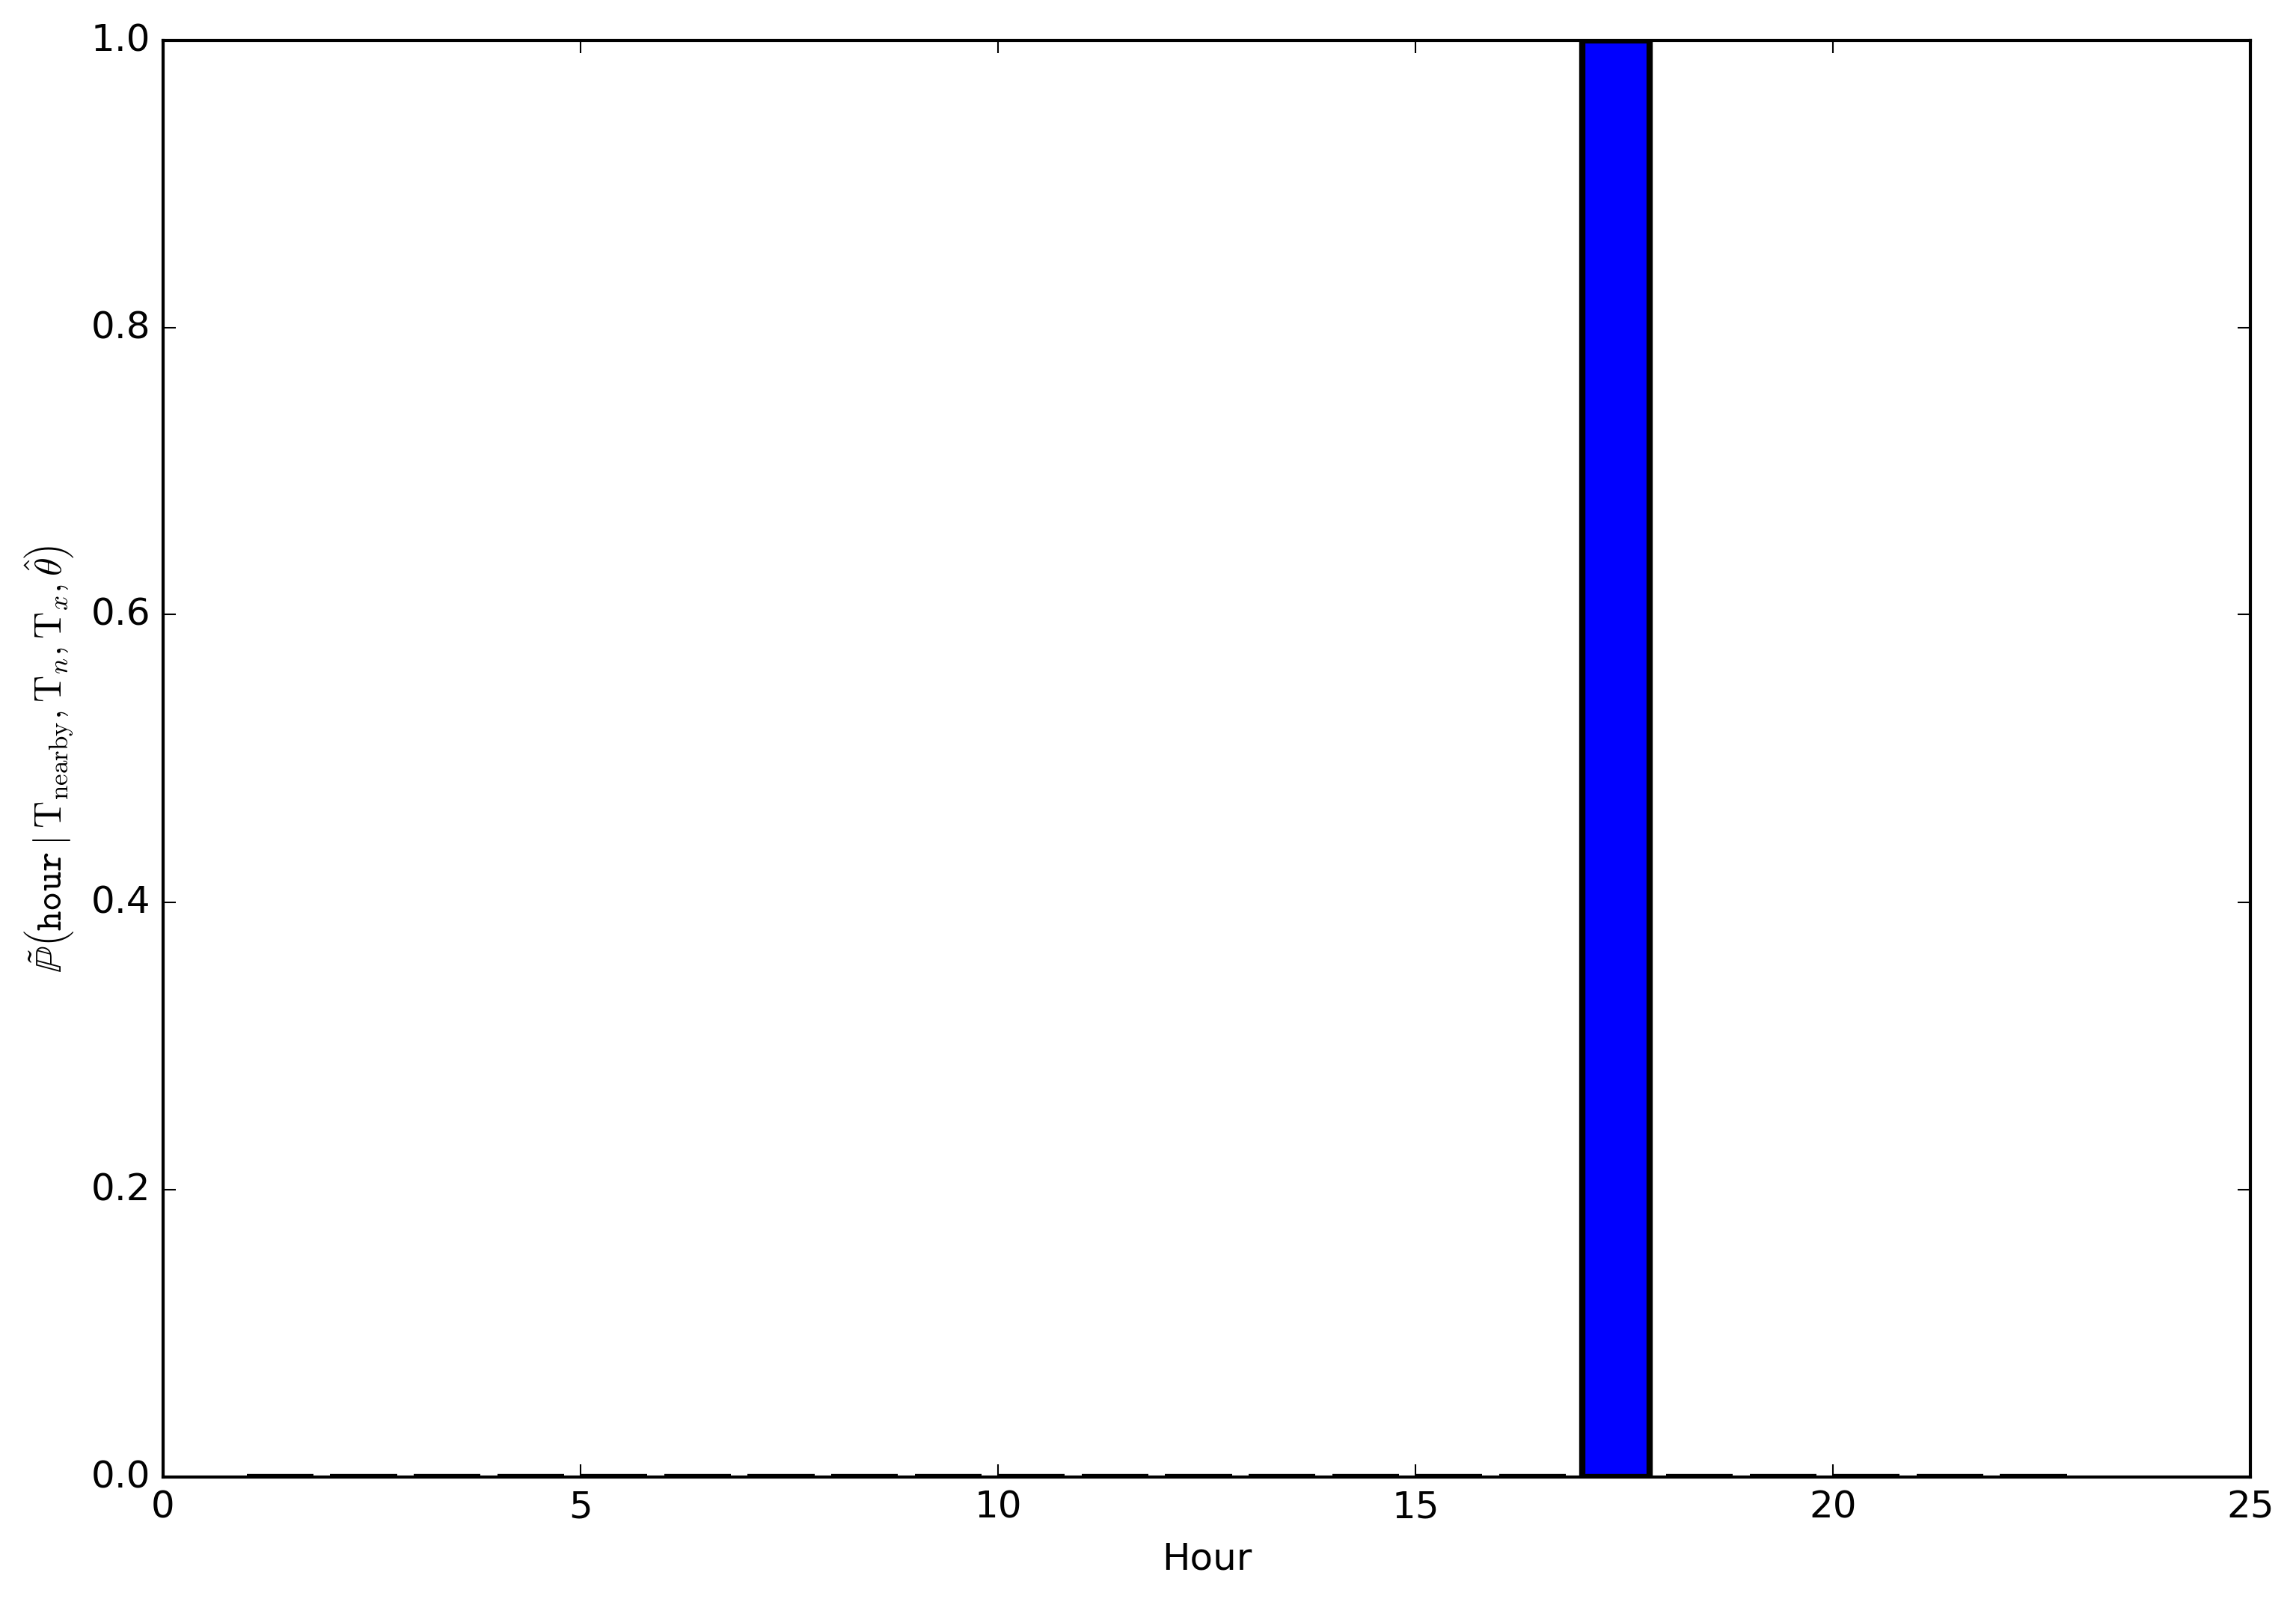

In [40]:
sumloglik_vec = [sumloglik_dict[hr] for hr in hours_vec]
prob_vec = exp(sumloglik_vec .- maximum(sumloglik_vec) .+ 10)
prob_vec ./= sum(prob_vec)
plt.bar(convert(Vector{Float64},hours_vec), prob_vec, linewidth=2)
plt.axvline(17, linestyle="--", color="black")
plt.xlabel("Hour")
plt.ylim(0,1)
# plt.text(3, 1.0, 
#     L"\tilde{\mathbb{P}}\left(\mathtt{hour} \mid \mathrm{T}_{\mathrm{nearby}}, \mathrm{T}_{n}, \mathrm{T}_{x},  \hat{\theta} \right)")
plt.ylabel(L"$\tilde{\mathbb{P}}\left(\mathtt{hour} \mid \mathrm{T}_{\mathrm{nearby}}, \mathrm{T}_{n}, \mathrm{T}_{x},  \hat{\theta} \right)$")
plt.savefig("figures/hr_pseudo_posterior.png")
plt.savefig("figures/hr_pseudo_posterior.pdf")

In [38]:
sum([prob_vec[1:16] ; prob_vec[18:end]])

3.2805771918373506e-27